In [29]:
import os
import math
import wandb
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import straug.blur as blur
import straug.warp as warp
import straug.noise as noise
import straug.camera as camera
import straug.process as process
import straug.geometry as geometry

from PIL import Image
from typing import Union
from torch import Tensor
from tabulate import tabulate
from tqdm.notebook import tqdm
from IPython.display import display
from pytorch_lightning import seed_everything
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchmetrics import CharErrorRate, WordErrorRate

seed_everything(1, True)
DEVICE = 'cuda:0'

Global seed set to 1


# Что из себя представляют данные

Сами изображения в двух папках, а их метки в файлах tcv:

In [30]:
os.listdir('./dataset/')

['old_test.tsv', 'old_train.tsv', 'test', 'test.tsv', 'train', 'train.tsv']

# Посмотрим на различия алфавита:

In [31]:
test_df = pd.read_csv('./dataset/test.tsv', delimiter='\t', names = ['Image name', 'Label'])
test_alphabet = set(test_df['Label'].to_string())

train_df = pd.read_csv('./dataset/train.tsv', delimiter='\t', names = ['Image name', 'Label'])
train_alphabet = set(train_df['Label'].to_string()) - set('\n')

old_train_df = pd.read_csv('./dataset/old_train.tsv', delimiter='\t', names = ['Image name', 'Label'])
old_train_alphabet = set(old_train_df['Label'].to_string()) - set('\n')

print(len(old_train_alphabet))
print(train_alphabet == old_train_alphabet)

93
True


In [32]:
len(sorted(test_df['Label'].values, key= lambda x: len(x), reverse=True)[0])

22

Так как были объединены 2 датасета, в одном из которых были казахские символы, отредактируем лейблинг, удалив/заменив буквы на русские аналоги. Так же в нем присутствовали ошибочные схожие символы английского алфавита. Все эти корректировки проверялись и редактировались вручную

In [33]:
for i in range(len(test_df['Image name'])):
    try:
        if len(set('ғҚқҮӨө–—…oH') - set(test_df.iloc[i][1])) != len(set('ғҚқҮӨө–—…oH')):
            print(test_df.iloc[i][0])
    except Exception:
        print(i)

После выполнения функции можно увидеть, что на некоторых картинках не хватает разметки. Дополним эту разметку

Также в данных были и ошибочные метки - ссылка, из-за которой добавлялись английские символы, сокращенный знак кавычек >> или <<. Все эти шумы отфильтровались или заменились на корректные символы

# Dataset class

In [55]:
class HWTDataset(Dataset):
    """
    Class for creating custom image2label dataset from folder

    Args:
        Dataset (Dataset): Standart torch class for custom datasets
    """
    
    
    def __init__(
        self,
        root_dir: str,
        label_dir: str,
        out_channels: int = 3,
        transforms: transforms.Compose = None) -> None:
        
        assert out_channels in [1, 3], 'Out channels must be 1 or 3'
        
        super(HWTDataset, self).__init__()
        
        name_label = pd.read_csv(label_dir, delimiter='\t', names = ['Image name', 'Label'])
        name_label['Image name'] = name_label['Image name'].apply(lambda x: os.path.join(root_dir, x))
        self.data = name_label.to_dict('split')['data']
        
        self.transforms = transforms
        self.out_channels = out_channels
    
    
    def __len__(self) -> int:
        return len(self.data)
    
        
    def __getitem__(self, index: int) -> tuple[Tensor, str]:
        
        path, label = self.data[index]
        img = Image.open(path).convert('RGB')
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        if img.shape[1] != self.out_channels:
            img = img.expand((self.out_channels, -1, -1))
        
        return img, label

# Decoder class

In [35]:
class SymbolCoder:
    """
    Class needs to encode initial text to Tensor
    and decode predicted labels to text
    """
    
    def __init__(self, alphabet) -> None:
        
        self.alphabet = alphabet
        self.sym2class, self.class2sym = {'' : 0}, {0 : ''}
        
        for num, alpha in enumerate(sorted(alphabet)):
            self.sym2class[alpha] = num + 1
            self.class2sym[num + 1] = alpha
    
    
    def encode(self, text) -> tuple[Tensor, Tensor]:
        """
        This method needs for encoding initial word to Tensor

        Args:
            text (str): Initial text for encode

        Returns:
            tuple: First value is a tensor of word(s) classes, second is length(s) of word(s)
        """
        
        length = []
        result = []
        
        for word in text:
            length.append(len(word))
            for alpha in word:
                if alpha in self.alphabet: 
                    result.append(self.sym2class[alpha])
                else: result.append(0)
        
        return (torch.tensor(result, dtype=torch.int64), torch.tensor(length, dtype=torch.int64))
    
    
    def decode(self, text, length) -> Union[str, list]:
        """
        This method used for decoding prediction classes to text

        Args:
            text (Tensor): predicted text(s)
            length (Tensor): length(s) of prediction text(s)

        Returns:
            str or list: list type returns when use for batch, for single word returns str
        """
        
        #For single word
        if length.numel() == 1:
            
            length = length[0]
            word = ''
            
            for i in range(length):
                if text[i] != 0 and not (i > 0 and text[i - 1] == text[i]):
                    word  += self.class2sym[text[i].item()]
            return word
        
        #For batch
        else:
            
            words = []
            index = 0
            
            for i in range(length.numel()):
                l = length[i]
                words.append(
                    self.decode(text[index:index + l], torch.IntTensor([l])))
                index += l
            return words
    
    
    def __len__(self):
        return len(self.class2sym)

# Augmentations

### Transforms 1

In [36]:
train_transform_1 = transforms.Compose([
    transforms.RandomApply([transforms.Grayscale(1)], 1),
    transforms.Resize((64, 224)),
    transforms.ToTensor()
])

test_transform_1 = transforms.Compose([
    transforms.RandomApply([transforms.Grayscale(1)], 1),
    transforms.Resize((64, 224)),
    transforms.ToTensor()
])

### Transforms 2

In [37]:
train_transform_2 = transforms.Compose([
    transforms.RandomApply([transforms.Grayscale(1)], 1),
    transforms.ColorJitter(contrast=(2, 3)),
    transforms.Resize((64, 224)),
    transforms.ToTensor()
])

test_transform_2 = transforms.Compose([
    transforms.RandomApply([transforms.Grayscale(1)], 1),
    transforms.ColorJitter(contrast=(2, 3)),
    transforms.Resize((64, 224)),
    transforms.ToTensor()
])

# RNN layer

In [38]:
class RNN(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self,
                 in_len,
                 out_len,
                 n_classes : int = None,
                 rnn_type : str = 'RNN',
                 bidirectional : bool = True,
                 batch_first : bool = True) -> None:
        
        super(RNN, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = getattr(nn, rnn_type)(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data) -> torch.Tensor:
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, D * n_hidden]
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [39]:
class Model(nn.Module):
    """
    This class use for slicing initial image
    """
    
    def __init__(self,
                 img_shape : tuple,
                 len_alphabet : int,
                 in_channels : int,
                 num_layers : int = 5,
                 increase_channels_layers : list = [0, 1, 3],
                 modules_seq : str = 'CAMB',
                 modules_freq : list = [1, 1, 1, 1],
                 conv_kernel_size : Union[int, tuple] = 3,
                 conv_stride : Union[int, tuple] = 1,
                 conv_padding : Union[int, tuple] = 1,
                 pool_kernel_size : Union[int, tuple] = 2,
                 pool_stride : Union[int, tuple] = 2,
                 pool_padding : Union[int, tuple] = 0,
                 activation : str = 'ReLU',
                 rnn_type : str = 'RNN'
                 ) -> None:
        
        assert rnn_type in ['RNN', 'GRU', 'LSTM'], 'RNN type must be RNN, GRU or LSTM'
        
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        out_channels = 64
        frequency = dict(zip(modules_seq, modules_freq))
        
        for layer in range(num_layers):
            
            for module in modules_seq:
                
                if (layer + 1) % frequency[module]:
                    continue
                
                if module == 'C':
                    self.layers.append(nn.Conv2d(in_channels, out_channels, conv_kernel_size,
                                                conv_stride, conv_padding))
                    in_channels = out_channels
                    img_shape = self.conv_output_shape(img_shape, conv_kernel_size, conv_stride, conv_padding)
                elif module == 'A':
                    self.layers.append(getattr(nn, activation)())
                elif module == 'M':
                    self.layers.append(nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding))
                    img_shape = self.conv_output_shape(img_shape, pool_kernel_size, pool_stride, pool_padding)
                elif module == 'B':
                    self.layers.append(nn.BatchNorm2d(out_channels))
            
            if layer in increase_channels_layers:
                out_channels *= 2
        
        self.rnn_layers = nn.Sequential(
            RNN(img_shape[0]*512, 256, rnn_type=rnn_type, bidirectional=True, batch_first=True),
            RNN(512, 256, len_alphabet + 1, rnn_type=rnn_type, bidirectional=True, batch_first=True)
        )
        
        print(f'Shape after convs layers: {img_shape}')
    
    
    def conv_output_shape(self, h_w, kernel_size=1, stride=1, pad=0, dilation=1) -> tuple:
        from math import floor
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
            
        if isinstance(stride, int):
            stride = (stride, stride)
            
        if isinstance(pad, int):
            pad = (pad, pad)
            
        h = floor( ((h_w[0] + (2 * pad[0]) - ( dilation * (kernel_size[0] - 1) ) - 1 ) / stride[0]) + 1)
        w = floor( ((h_w[1] + (2 * pad[0]) - ( dilation * (kernel_size[1] - 1) ) - 1 ) / stride[1]) + 1)
        return (h, w)
    
    
    def forward(self, data):
        
        for module in self.layers:
            data = module(data)
        
        bs, c, h, w = data.shape
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

In [40]:
model = Model((64, 224),len(train_alphabet),in_channels = 1,num_layers = 7,modules_seq='CBAM',modules_freq=[1,1,1,2])

Shape after convs layers: (8, 28)


# Model 1

In [41]:
class RNN1(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self, in_len, out_len, type = 'RNN', n_classes = None,
                 bidirectional = True, batch_first = True) -> None:
        
        super(RNN1, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = nn.__dict__.get(type)(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data):
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, [1, 2] * n_hidden], 1 if bidir = False, else 2
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [42]:
class Model1(nn.Module):
    """
    This class use for slicing initial image
    """
    
    def __init__(self, len_alphabet) -> None:
        super(Model1, self).__init__()
        
        # In - 3x64x224
        self.layer_1 = nn.Sequential()
        self.layer_1.add_module('1', nn.Conv2d(3, 8, 3))
        self.layer_1.add_module('act', nn.ReLU())
        self.layer_1.add_module('2', nn.MaxPool2d(2, (2, 1), 1))
        self.layer_1.add_module('3', nn.BatchNorm2d(8))
        # Out - 8x32x224
        
        # In - 8x32x224
        self.layer_2 = nn.Sequential()
        self.layer_2.add_module('1', nn.Conv2d(8, 64, 3))
        self.layer_2.add_module('act', nn.ReLU())
        self.layer_2.add_module('2', nn.MaxPool2d(2, 2, 1))
        self.layer_2.add_module('3', nn.BatchNorm2d(64))
        # Out - 64x16x224
        
        # In - 64x16x112
        self.layer_3 = nn.Sequential()
        self.layer_3.add_module('1', nn.Conv2d(64, 256, 3))
        self.layer_3.add_module('act', nn.ReLU())
        self.layer_3.add_module('2', nn.MaxPool2d(2, 2))
        self.layer_3.add_module('3', nn.BatchNorm2d(256))
        # Out - 256x8x56
        
        # In - 256x8x56
        self.layer_4 = nn.Sequential()
        self.layer_4.add_module('1', nn.Conv2d(256, 512, 3))
        self.layer_4.add_module('act', nn.ReLU())
        self.layer_4.add_module('2', nn.MaxPool2d(2, 2))
        self.layer_4.add_module('3', nn.BatchNorm2d(512))
        # Out - 512x2x28

        self.rnn_layers = nn.Sequential(
            RNN1(2*512, 256, bidirectional=True, batch_first=True),
            RNN1(512, 256, len_alphabet + 1, bidirectional=True, batch_first=True)
        )
        
    
    def forward(self, data):
        
        data = self.layer_1(data)
        data = self.layer_2(data)
        data = self.layer_3(data)
        data = self.layer_4(data)
        # bs, c, h, w
        
        bs, c, h, w = data.shape
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

# Model 2

Усложнил модель свертки, добаил больше слоев, заменил ReLU на LeakyReLU. Пробовал увеличить количество рекуррентных слоев, но практика показала, что больше 2-х ставить нет смысла. На выходе число входов в реккурентные слои в 4 раза больше, чем в первой модели Пока самая лучшая модель. Обучал с планировщиком на 25 эпохах с понижением скорости с 0.0003 до 0.00003. 

In [43]:
class RNN2(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self, in_len, out_len, n_classes = None,
                 bidirectional = True, batch_first = True) -> None:
        
        super(RNN2, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = nn.RNN(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data):
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, [1, 2] * n_hidden], 1 if bidir = False, else 2
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [44]:
class Model2(nn.Module):
    """
    In this model I complicated the architechture by adding
    more layers and changing ReLU to LeakyReLU
    """
    
    def __init__(self, len_alphabet) -> None:
        super(Model2, self).__init__()
        
        # In - 3x64x224
        self.layer_1 = nn.Sequential()
        self.layer_1.add_module('1', nn.Conv2d(1, 64, 3, padding=1))
        self.layer_1.add_module('2', nn.BatchNorm2d(64))
        self.layer_1.add_module('3', nn.LeakyReLU())
        # Out - 64x64x224
        
        # In - 64x64x224
        self.layer_2 = nn.Sequential()
        self.layer_2.add_module('1', nn.Conv2d(64, 128, 3, padding=1))
        self.layer_2.add_module('2', nn.BatchNorm2d(128))
        self.layer_2.add_module('3', nn.LeakyReLU())
        self.layer_2.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 128x32x112
        
        # In - 128x32x112
        self.layer_3 = nn.Sequential()
        self.layer_3.add_module('1', nn.Conv2d(128, 256, 3, padding=1))
        self.layer_3.add_module('2', nn.BatchNorm2d(256))
        self.layer_3.add_module('3', nn.LeakyReLU())
        # Out - 256x32x112
        
        # In - 256x32x112
        self.layer_4 = nn.Sequential()
        self.layer_4.add_module('1', nn.Conv2d(256, 256, 3, padding=1))
        self.layer_4.add_module('2', nn.BatchNorm2d(256))
        self.layer_4.add_module('3', nn.LeakyReLU())
        self.layer_4.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 256x16x56
        
        # In - 256x16x56
        self.layer_5 = nn.Sequential()
        self.layer_5.add_module('1', nn.Conv2d(256, 512, 3, padding=1))
        self.layer_5.add_module('2', nn.BatchNorm2d(512))
        self.layer_5.add_module('3', nn.LeakyReLU())
        # Out - 512x16x56
        
        # In - 512x16x56
        self.layer_6 = nn.Sequential()
        self.layer_6.add_module('1', nn.Conv2d(512, 512, 3, padding=1))
        self.layer_6.add_module('2', nn.BatchNorm2d(512))
        self.layer_6.add_module('3', nn.LeakyReLU())
        self.layer_6.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 512x8x28
        
        # In - 512x8x28
        self.layer_7 = nn.Sequential()
        self.layer_7.add_module('1', nn.Conv2d(512, 512, 3, padding=1))
        self.layer_7.add_module('2', nn.BatchNorm2d(512))
        self.layer_7.add_module('3', nn.LeakyReLU())
        # Out - 512x8x28
        
        self.rnn_layers = nn.Sequential(
            RNN2(8*512, 512, bidirectional=True, batch_first=True),
            RNN2(2*512, 128, len_alphabet + 1, bidirectional=True, batch_first=True)
        )
        
    
    def forward(self, data):
        
        data = self.layer_1(data)
        data = self.layer_2(data)
        data = self.layer_3(data)
        data = self.layer_4(data)
        data = self.layer_5(data)
        data = self.layer_6(data)
        data = self.layer_7(data)
        # bs, c, h, w
        
        bs, c, h, w = data.shape
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

# Model 3

Тут попробовал увеличить длину входящей последовательности, однаако обучить модель до приемлевого качества (хотя бы аналогично 2 модели) не получилось. Пробовал разные размеры батча и скорости обучения, ставил разные скедулеры, модель нужно модернизировать (скорее всего стоит заменить простой RNN), либо уменьшать длину последовательности

In [45]:
class RNN3(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self, in_len, out_len, n_classes = None,
                 bidirectional = True, batch_first = True) -> None:
        
        super(RNN3, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = nn.RNN(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data):
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, [1, 2] * n_hidden], 1 if bidir = False, else 2
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [46]:
class Model3(nn.Module):
    """
    In this model I increased sequence length
    and removed LeakyReLU layer
    """
    
    def __init__(self, len_alphabet) -> None:
        super(Model3, self).__init__()
        
        # In - 1x64x224
        self.layer_1 = nn.Sequential()
        self.layer_1.add_module('1', nn.Conv2d(1, 64, 5))
        self.layer_1.add_module('2', nn.BatchNorm2d(64))
        # Out - 64x60x220
        
        # In - 64x60x220
        self.layer_2 = nn.Sequential()
        self.layer_2.add_module('1', nn.Conv2d(64, 128, 5))
        self.layer_2.add_module('2', nn.BatchNorm2d(128))
        self.layer_2.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 128x28x108
        
        # In - 128x28x108
        self.layer_3 = nn.Sequential()
        self.layer_3.add_module('1', nn.Conv2d(128, 256, 5))
        self.layer_3.add_module('2', nn.BatchNorm2d(256))
        # Out - 256x24x104
        
        # In - 256x24x104
        self.layer_4 = nn.Sequential()
        self.layer_4.add_module('1', nn.Conv2d(256, 256, 5))
        self.layer_4.add_module('2', nn.BatchNorm2d(256))
        self.layer_4.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 256x10x50
        
        # In - 256x10x50
        self.layer_5 = nn.Sequential()
        self.layer_5.add_module('1', nn.Conv2d(256, 512, 5))
        self.layer_5.add_module('2', nn.BatchNorm2d(512))
        # Out - 512x6x46
        
        # In - 512x6x46
        self.layer_6 = nn.Sequential()
        self.layer_6.add_module('1', nn.Conv2d(512, 512, 5))
        self.layer_6.add_module('3', nn.LeakyReLU())
        # Out - 512x2x42

        self.rnn_layers = nn.Sequential(
            RNN3(2*512, 256, bidirectional=True, batch_first=True),
            RNN3(2*256, 128, len_alphabet + 1, bidirectional=True, batch_first=True)
        )
        
    
    def forward(self, data):
        data = self.layer_1(data)
        data = self.layer_2(data)
        data = self.layer_3(data)
        data = self.layer_4(data)
        data = self.layer_5(data)
        data = self.layer_6(data)
        
        # bs, c, h, w
        
        bs, c, h, w = data.shape
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

# Model 4

Решил взять 3ю модель и заменить RNN на GRU. Думаю, таким образом решится проблема с невозможностью обучения на длинных последовательностях

In [47]:
class RNN4(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self, in_len, out_len, n_classes = None,
                 bidirectional = True, batch_first = True) -> None:
        
        super(RNN4, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = nn.GRU(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data):
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, [1, 2] * n_hidden], 1 if bidir = False, else 2
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [48]:
class Model4(nn.Module):
    """
    In this model I increased sequence length
    and removed LeakyReLU layer
    """
    
    def __init__(self, len_alphabet) -> None:
        super(Model4, self).__init__()
        
        # In - 1x64x224
        self.layer_1 = nn.Sequential()
        self.layer_1.add_module('1', nn.Conv2d(1, 64, 5))
        self.layer_1.add_module('2', nn.BatchNorm2d(64))
        # Out - 64x60x220
        
        # In - 64x60x220
        self.layer_2 = nn.Sequential()
        self.layer_2.add_module('1', nn.Conv2d(64, 128, 5))
        self.layer_2.add_module('2', nn.BatchNorm2d(128))
        self.layer_2.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 128x28x108
        
        # In - 128x28x108
        self.layer_3 = nn.Sequential()
        self.layer_3.add_module('1', nn.Conv2d(128, 256, 5))
        self.layer_3.add_module('2', nn.BatchNorm2d(256))
        # Out - 256x24x104
        
        # In - 256x24x104
        self.layer_4 = nn.Sequential()
        self.layer_4.add_module('1', nn.Conv2d(256, 256, 5))
        self.layer_4.add_module('2', nn.BatchNorm2d(256))
        self.layer_4.add_module('4', nn.MaxPool2d(2, 2))
        # Out - 256x10x50
        
        # In - 256x10x50
        self.layer_5 = nn.Sequential()
        self.layer_5.add_module('1', nn.Conv2d(256, 512, 5))
        self.layer_5.add_module('2', nn.BatchNorm2d(512))
        # Out - 512x6x46
        
        # In - 512x6x46
        self.layer_6 = nn.Sequential()
        self.layer_6.add_module('1', nn.Conv2d(512, 512, 5))
        self.layer_6.add_module('3', nn.LeakyReLU())
        # Out - 512x2x42

        self.rnn_layers = nn.Sequential(
            RNN4(2*512, 256, bidirectional=True, batch_first=True),
            RNN4(2*256, 128, len_alphabet + 1, bidirectional=True, batch_first=True)
        )
        
    
    def forward(self, data):
        data = self.layer_1(data)
        data = self.layer_2(data)
        data = self.layer_3(data)
        data = self.layer_4(data)
        data = self.layer_5(data)
        data = self.layer_6(data)
        
        # bs, c, h, w
        
        bs, c, h, w = data.shape
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # bs, w, h * c equal to N, L, H
        data = self.rnn_layers(data) # N, L, len_alphabet
        data = data.permute(1, 0, 2) # L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

# Pretty info output

In [49]:
def print_epoch_data(epoch, mean_loss, char_error, word_error, zero_out_losses):
    
    print(tabulate([['epoch', 'mean loss', 'mean cer', 'mean wer', 'zero loss warnings'],
                    [epoch, round(mean_loss, 4), round(char_error, 4),
                    round(word_error, 4), zero_out_losses]],
                   headers='firstrow', tablefmt='fancy_grid'))

# Train functions

### Saving model and logging statistics

In [50]:
def print_save_stat(outputs, epoch, model, scheduler, model_name, zero_out, LOGGING = False):
    
    if len(outputs) == 0:
        print('ERROR: bad loss')
        raise Exception
        
    output = torch.Tensor(outputs)
    mean_loss = output[:, 0].mean()
    char_error = output[:, 1].mean()
    word_error = output[:, 2].mean()
    print_epoch_data(epoch, mean_loss.item(), char_error.item(), word_error.item(), zero_out)
    
    if LOGGING:
        wandb.log({'loss': mean_loss.item(),
                'CER': char_error.item(),
                'WER': word_error.item(),
                'Learn Rate': scheduler.get_last_lr()[-1]})
    
    if char_error < 0.1:
        torch.save(model.state_dict(),
                   f'./{model_name}_L-{round(mean_loss.item(), 4)}_CER-{round(char_error.item(), 4)}.pth')

### Train

In [51]:
def train(model, optimizer, scheduler, dataloader, lossfunc, epochs, model_name, LOGGING = False):
    
    model.train()
    coder = SymbolCoder(train_alphabet)
    CER = CharErrorRate()
    WER = WordErrorRate()
    if LOGGING:
        wandb.watch(model, lossfunc, log='all', log_freq=100)
    
    for epoch in tqdm(range(epochs), total=epochs):
        
        zero_out_losses = 0
        outputs = []
        
        for batch_nb, (data, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            optimizer.zero_grad()
            
            classes, lengths = coder.encode(targets)
            
            data = data.to(DEVICE)
            classes = classes.to(DEVICE)
            length = lengths.to(DEVICE)
            
            logits = model(data)
            logits = logits.contiguous().cpu()
            T, N, C = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(N)]).to(DEVICE)
            classes = classes.view(-1).contiguous()
            loss = lossfunc(logits, classes, pred_sizes, lengths)
            
            if (torch.zeros(loss.size()) == loss).all():
                zero_out_losses += 1
                continue
            
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = coder.decode(preds.data, pred_sizes.data)
            
            cer = CER(sim_preds, targets)
            wer = WER(sim_preds, targets)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            output = [abs(loss.item()), cer, wer]
            outputs.append(output)
            print(output)
        
        print_save_stat(outputs, epoch, model, scheduler, model_name, zero_out_losses, LOGGING)

# Config

### Wandb, Transform and Model type

In [64]:
LOGGING = False # if False wandb will not log
ID_RESUME = None # if not none wandb will continue log for this id run
TRANSFORM = 1
MODEL = 4
DATASET = 'old_'
EPOCHS = 30
SCHEDULER = 'StepLR'
OUT_CHANNELS = 1

if ID_RESUME and LOGGING:
    wandb.init(
        id='35odcpyv',
        project="Handwritten text recognition",
        resume='must'
    )
elif LOGGING:
    wandb.init(
        project="Handwritten text recognition",
        config={
            "Model type": f'Model {MODEL}',
            "Transform type": f'Transform {TRANSFORM}',
            "architecture": "RCNN",
            "dataset": "Handwritten Cyrillic dataset" if DATASET == 'old_' else 'Custom dataset',
            "epochs": EPOCHS,
            "name": f"M={MODEL}_T={TRANSFORM}_LR={SCHEDULER}"
        }
    )

### Data loading

In [65]:
train_transform = locals().get(f'train_transform_{TRANSFORM}')
test_transform = locals().get(f'test_transform_{TRANSFORM}')

train_data = HWTDataset('./dataset/train/', f'./dataset/{DATASET}train.tsv', OUT_CHANNELS, train_transform)
test_data = HWTDataset('./dataset/test/', f'./dataset/{DATASET}test.tsv', OUT_CHANNELS, test_transform)

torch.Size([1, 64, 224])


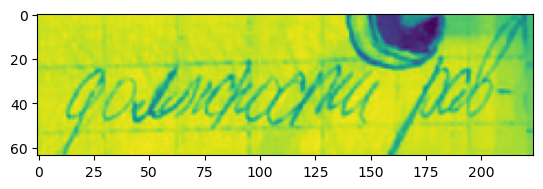

In [66]:
x = train_data[-1]
plt.imshow(x[0].permute(1, 2, 0))
print(x[0].shape)

### Model

In [58]:
Model = locals().get(f'Model{MODEL}')

ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)
model = Model(len(train_alphabet))
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
dataloader = DataLoader(train_data, 8, True) # Если ставить батч 16, то лосс не падает
scheduler = torch.optim.lr_scheduler.__dict__.get(SCHEDULER)(optimizer, 15 * len(dataloader), 0.1)

# Training stage

In [ ]:
train(model, optimizer, scheduler, dataloader, ctc_loss, EPOCHS, f'M{MODEL}_T{TRANSFORM}', LOGGING)

# Evaluation stage

### Word correction based on external dictionary

In [59]:
def word_correction(predictions):
    
    import enchant
    
    CER = CharErrorRate()
    correct_predictions = []
    dictionary = enchant.Dict("ru_RU")
    
    for word in tqdm(predictions, total=len(predictions)):

        words = word.split()
        result = ''

        for word in words:
            if word.isalpha():
                
                sim = dict()
                
                if dictionary.check(word):
                    result += word + ' '
                    continue
                
                suggestions = set(dictionary.suggest(word))

                for suggest in suggestions:
                    if ' ' not in suggest:
                        measure = CER(suggest, word)
                        sim[measure] = suggest
                if len(sim.keys()) > 0: 
                    result += sim[min(sim.keys())] + ' '
                    continue
            result += word + ' '

        correct_predictions.append(result[:-1])
    return correct_predictions

### Count statistics about incorrect symbol prediction

In [60]:
def errors_sym_stat(preds, targets):
    
    sym_er = {}
    length_word_CER = {}
    CER = CharErrorRate()
    
    for pred, true in zip(preds, targets):
        if len(true) in length_word_CER.keys():
            length_word_CER[len(true)].append(CER(pred, true))
        else: length_word_CER[len(true)] = [CER(pred, true)]
        if len(true) == len(pred) and true != pred:
            for i, j in zip(pred, true):
                if i != j: 
                    if j in sym_er.keys(): 
                        if i in sym_er[j].keys():
                            sym_er[j][i] += 1
                        else: sym_er[j][i] = 1
                    else: sym_er[j] = {i : 1}
    
    similar_sym = {}
    for true_sym in sym_er:
        for pred_sym in sym_er[true_sym]:
            if sym_er[true_sym][pred_sym] >= 10:
                if pred_sym in similar_sym.keys(): 
                    similar_sym[pred_sym].update({true_sym : sym_er[true_sym][pred_sym]})
                else: similar_sym[pred_sym] = {true_sym : sym_er[true_sym][pred_sym]}

    length_word_CER = {key : torch.Tensor(length_word_CER[key]).mean().item()
                       for key in length_word_CER.keys()}

    
    return similar_sym, length_word_CER

### Model eval

In [61]:
def evaluate(model, loader, correcting = False, count_err_stat = False):
    
    model = model.eval()
    CER = CharErrorRate()
    WER = WordErrorRate()
    coder = SymbolCoder(train_alphabet)
    labels, predictions = [], []
    
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch[0].to(DEVICE), batch[1]
        labels.extend(targets)
        logits = model(input_)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = coder.decode(pos.data, pred_sizes.data)
        predictions.extend(sim_preds)
    
    if correcting: predictions = word_correction(predictions)
    
    char_error = CER(predictions, labels)
    word_error = WER(predictions, labels)
    print({'char_error' : char_error, 'word_error' : word_error})
    
    if count_err_stat: return errors_sym_stat(predictions, labels)

Обычная оценка тестовых данных, без коррекции слов 

In [67]:
model = Model2(len(train_alphabet))
model.load_state_dict(torch.load('./M2_T2_L-0.0456_CER-0.0132_OLD.pth'))
model.to(DEVICE)
loader = torch.utils.data.DataLoader(test_data, batch_size = 16)

In [29]:
evaluate(model, loader)

  0%|          | 0/97 [00:00<?, ?it/s]

{'char_error': tensor(0.1982), 'word_error': tensor(0.6912)}


С проверкой орфографии слов. Нужно заменить словарь и способ подбора похожих слов, он мне не очень нравится.

In [30]:
evaluate(model, loader, correcting=True)

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/1544 [00:00<?, ?it/s]

{'char_error': tensor(0.2123), 'word_error': tensor(0.5735)}


Видно, что CER немного поднялся, однако качество определения слов возросло на 12%

Посмотрим какие символы чаще путает наша модель, а также ошибки в зависимости от длины последовательности. На основе этой статистики возможно реализовать замену вероятных ошибочных символов и искать ближайшее совпадение в словаре (с учетом того, что в нашем тексте нет требований к сохранению четкой орфографии писавшего человека). А на основе соотношения длины к ошибке можно изменить модель - увеличить или уменьшить входящую в RNN последовательность

In [31]:
stat = evaluate(model, loader, count_err_stat=True)
print(stat[0])

  0%|          | 0/97 [00:00<?, ?it/s]

{'char_error': tensor(0.1993), 'word_error': tensor(0.6931)}
{'п': {'л': 11}, 'я': {'е': 14, 'а': 14}, 'и': {'е': 11, 'н': 24}, 'с': {'е': 17}, 'а': {'о': 14}, 'е': {'и': 18, 'с': 14}, 'н': {'к': 14, 'п': 15, 'м': 12}, 'о': {'а': 29, '0': 12}, 'к': {'н': 15, 'х': 11}, 'л': {'м': 19}, 'р': {'д': 10}}


Посмотрим на CER в зависимости от длины последовательности

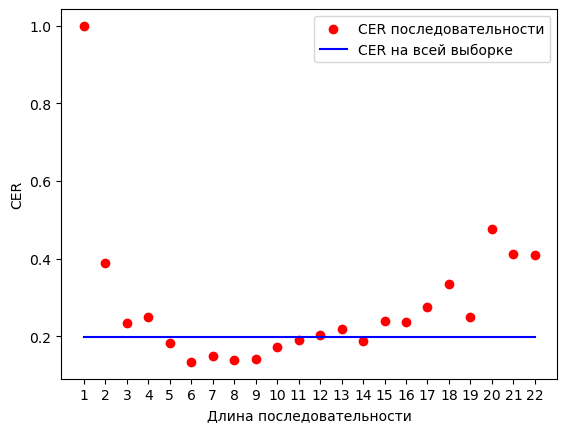

In [32]:
x = list(dict(sorted(stat[1].items())).keys())
y = dict(sorted(stat[1].items())).values()

plt.ylabel('CER')
plt.xlabel('Длина последовательности')
plt.xticks(x)
plt.scatter(x, y, color = 'red', label = 'CER последовательности')
plt.plot(x, [0.197 for i in x], color = 'blue', label = 'CER на всей выборке')
plt.legend(loc='best')

In [38]:
with torch.no_grad():
    torch.cuda.empty_cache()

Посмотрим на этот же график на тренировочных данных. Ограничение последовательности нашей модели - 28 знаков, поэтому значение CER начало сильно увеличиваться уже после 20-21 знака

  0%|          | 0/4518 [00:00<?, ?it/s]

{'char_error': tensor(0.0126), 'word_error': tensor(0.0498)}


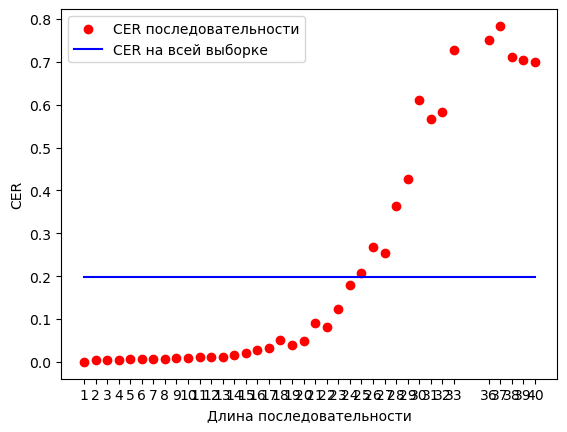

In [29]:
loader = torch.utils.data.DataLoader(train_data, batch_size = 16)
stat = evaluate(model, loader, count_err_stat=True)

x = list(dict(sorted(stat[1].items())).keys())
y = dict(sorted(stat[1].items())).values()

plt.ylabel('CER')
plt.xlabel('Длина последовательности')
plt.xticks(x)
plt.scatter(x, y, color = 'red', label = 'CER последовательности')
plt.plot(x, [0.197 for i in x], color = 'blue', label = 'CER на всей выборке')
plt.legend(loc='best')

### Тестирование модели, обученной на первом датасете, на новом датасете

После добавления нового датасета, решил протестировать модель на новых данных. Результат оказался неплохим - CER = 0.26, WER = 0.75. То есть после добавления абсолютно новых данных сеть ухудшила показатели на 10%.

In [112]:
test_data = HWTDataset('./dataset/test/', './dataset/test.tsv', test_transform)
loader = torch.utils.data.DataLoader(test_data, batch_size = 16)

In [113]:
evaluate(model, loader)

  0%|          | 0/1352 [00:00<?, ?it/s]

{'char_error': tensor(0.2627), 'word_error': tensor(0.7591)}


Аналогично проверим результаты с коррекцией слов:

In [114]:
evaluate(model, loader, correcting=True)

  0%|          | 0/1352 [00:00<?, ?it/s]

  0%|          | 0/10822 [00:00<?, ?it/s]

{'char_error': tensor(0.3228), 'word_error': tensor(0.7045)}


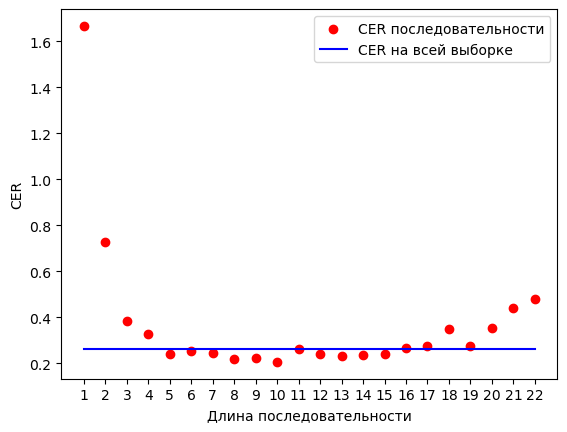

In [117]:
x = list(dict(sorted(stat[1].items())).keys())
y = dict(sorted(stat[1].items())).values()

plt.ylabel('CER')
plt.xlabel('Длина последовательности')
plt.xticks(x)
plt.scatter(x, y, color = 'red', label = 'CER последовательности')
plt.plot(x, [0.262 for i in x], color = 'blue', label = 'CER на всей выборке')
plt.legend(loc='best')

Видим, что при разных тестовых данных сеть все равно ухудшает качество распознавания на слишком коротких или слишком длинных последовательностях

# Final prediction and display results

In [30]:
def predict(model, img, correcting = False):
    
    CER = CharErrorRate()
    coder = SymbolCoder(train_alphabet)
    
    logits = model(img.to(DEVICE))
    logits = logits.contiguous().cpu()
    T, B, H = logits.size()
    pred_sizes = torch.LongTensor([T for i in range(B)])
    probs, pos = logits.max(2)
    pos = pos.transpose(1, 0).contiguous().view(-1)
    predictions = coder.decode(pos.data, pred_sizes.data)
    
    if correcting: predictions = word_correction(predictions)
        
    return predictions

In [34]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 9, shuffle=True)

  0%|          | 0/9 [00:00<?, ?it/s]

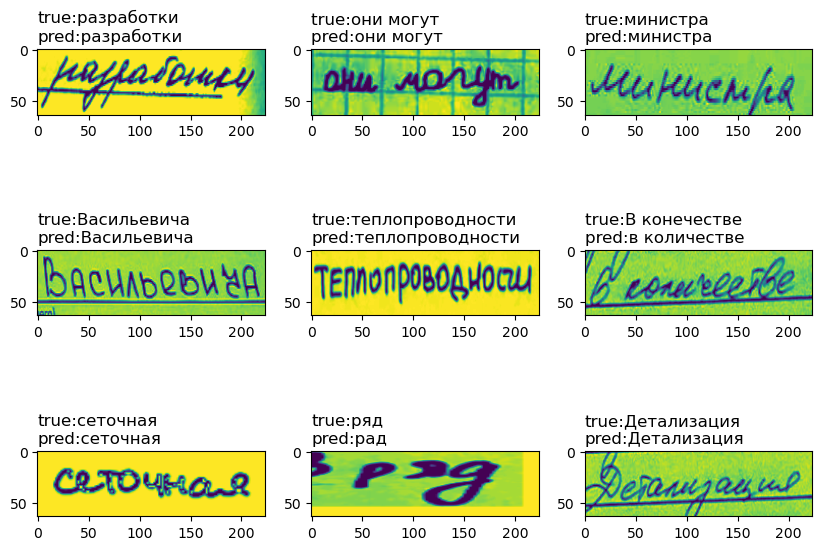

In [35]:
import matplotlib.pyplot as plt

examples = []
idx = 0
coder = SymbolCoder(train_alphabet)

for n, batch in enumerate(test_loader):
    if n <= 4: continue
    img, true_label = batch[0], batch[1]
    pred_label = predict(model, img, True)
    examples = [img, true_label, pred_label]
    break
fig = plt.figure(figsize=(10, 10))
rows = int(9 / 4) + 2
columns = int(9 / 8) + 2
for j in range(len(examples[-1])):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(examples[0][j].permute(1, 2, 0) * 0.5 + 0.5) #denormalize data
    plt.title('true:' + examples[1][j] + '\npred:' + examples[2][j], loc = 'left')